Author: Skyler Morris <br>

CoherentBraid.ipynb: <br>
Sets up and runs a braiding process for a $v = \frac{1}{3}$ FQH system on a cylinder <br>
as described by Kirmani et al., PHYSICAL REVIEW B 108, 064303 (2023). <br>
on classical and quantum hardware. 

In [8]:
import matplotlib.pyplot as plt
import sys, os
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit_aer import AerSimulator
from qiskit import transpile
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..")))
from tools.coherent.waveFunctions import (h1_position, construct_wavefunction, integrate_C1_or_C2_segment, 
                           integrate_C1_or_C2_segment_truncated)
from tools.coherent.fullCircuit import (create_truncated_wavefunction, compute_alphas,
                         create_ground_state_prep_3q,create_truncated_wavefunction, create_ground_state_prep_3q)


Set the number of $q$ quasihole sites, $ L_x, \kappa , y_t , y_b , y_2,$ and $h_2$ for Eq. (4) as seen in Fig. (1).

In [7]:
T = 1500  
N_sites = 24
Lx = 15
kappa = 2 * np.pi / Lx  
yt = 60 * kappa  
y2 = 34 * kappa
h2 = np.array([Lx / 2, y2])

flux_mod_pi = np.array([0, 1, 2, 3, 4, 5])
yb_values = 1/4 * (yt - (4 * (flux_mod_pi * np.pi / Lx)))

Effective flux through loop $\tilde{\Phi} = \big( L_x(y_t-y_b) \big) \text{mod}(6*\pi)$

In [3]:
flux = Lx * (yt - yb_values)
print(np.round((flux % (6 * np.pi))/np.pi))

[0. 1. 2. 3. 4. 5.]


Integrate along top and bottom contours (described in Kirmani et al.) resulting in the expected berry phase exhange. 

In [4]:

berry_phases = []

for yb in yb_values:
    #print(f"\nRunning for yb = {yb:.4f}")

    h1_start_c1 = h1_position(0, T, Lx, yt, y2, yb)
    h1_start_c2 = h1_position(2*T, T, Lx, yt, y2, yb)
    #h1_start_c3 = h1_position(T, T, Lx, yt, y2, yb)
    #h1_start_c4 = h1_position(3*T, T, Lx, yt, y2, yb)

    psi_start_c1 = construct_wavefunction(N_sites, h1_start_c1, h2, 0, T, kappa)
    psi_start_c2 = construct_wavefunction(N_sites, h1_start_c2, h2, 2*T, T, kappa)
    #psi_start_c3 = construct_wavefunction(N_sites, h1_start_c3, h2, T, T, kappa)
    #psi_start_c4 = construct_wavefunction(N_sites, h1_start_c4, h2, 3*T, T, kappa)


    out_c1 = integrate_C1_or_C2_segment(0, T, T, Lx, yt, y2, yb, N_sites, psi_start_c1.copy(), kappa)
    out_c2 = integrate_C1_or_C2_segment(2*T, 3*T, T, Lx, yt, y2, yb, N_sites, psi_start_c2.copy(), kappa)
    #out_c3 = integrate_C1_or_C2_segment(T, 2*T, T, Lx, yt, y2, yb, N_sites, psi_start_c2.copy(), kappa)
    #out_c4 = integrate_C1_or_C2_segment(3*T, 4*T, T, Lx, yt, y2, yb, N_sites, psi_start_c2.copy(), kappa)

    psi_final1 = out_c1["final_state"]
    psi_final2 = out_c2["final_state"]
    #psi_final3 = out_c3["final_state"]
    #psi_final4 = out_c4["final_state"]

    overlap1 = np.vdot(psi_start_c1, psi_final1)
    overlap2 = np.vdot(psi_start_c2, psi_final2)
    #overlap3 = np.vdot(psi_start_c3, psi_final3)
    #overlap4 = np.vdot(psi_start_c4, psi_final4)

    phase1 = np.angle(overlap1)
    phase2 = np.angle(overlap2)
    #phase3 = np.angle(overlap3)
    #phase4 = np.angle(overlap4)

    #print(phase3)
    #print(phase4)

    #berry_phases.append(phase1+phase2+phase3+phase4)
    berry_phases.append(phase1+phase2)

berry_phases = np.array(berry_phases)
total_berry_phase = np.sum(berry_phases)

print("\n Berry Phases")
for i, (yb, phi) in enumerate(zip(yb_values, berry_phases)):
    print(f"yb[{i}] = {yb:.4f}, phase = {phi:.4f} rad  ({phi / np.pi:.4f} π)")





 Berry Phases
yb[0] = 6.2832, phase = 2.1252 rad  (0.6765 π)
yb[1] = 6.0737, phase = 1.0782 rad  (0.3432 π)
yb[2] = 5.8643, phase = 0.0311 rad  (0.0099 π)
yb[3] = 5.6549, phase = -1.0160 rad  (-0.3234 π)
yb[4] = 5.4454, phase = -2.0630 rad  (-0.6567 π)
yb[5] = 5.2360, phase = -3.1101 rad  (-0.9900 π)


Results (in alignment with Kirmani fig. (2))

[-0.3332928   0.67649152]


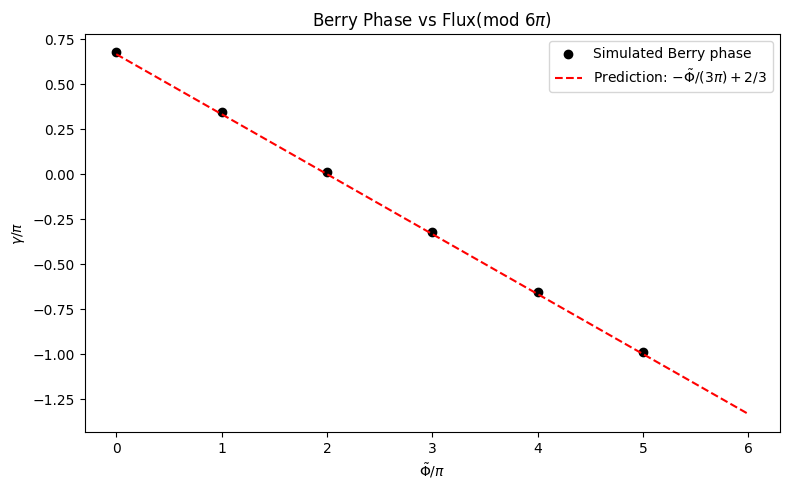

In [5]:
flux_mod_6pi = ((flux % (6 * np.pi))/np.pi)

#berry_phases[] += 2 * np.pi
coefficients = np.polyfit(flux_mod_6pi, berry_phases / np.pi, 1)
fit_func = np.poly1d(coefficients)
print(coefficients)

plt.figure(figsize=(8, 5))
plt.scatter(flux_mod_6pi, berry_phases / np.pi, color='black', label='Simulated Berry phase')

#plt.plot(np.linspace(0, 6, 200), fit_func(np.linspace(0, 6, 200)), 'purple', linestyle='--', label='Linear Fit')
plt.plot(np.linspace(0, 6, 200), -np.linspace(0, 6, 200)/3 + 2/3, 'r--', label=r"Prediction: $-\tilde{\Phi}/(3\pi) + 2/3$")

plt.title(r"Berry Phase vs Flux(mod 6$\pi$)")
plt.xlabel(r"$\tilde{\Phi}/\pi$")
plt.ylabel(r"$\gamma/\pi$")
plt.legend()
plt.tight_layout()
plt.show()


Truncating the parent Hamiltonian as described in the reference and exponentiating the along the same contour as above, the unitary that takes an initial ground state and braids it is generated and stored for each $y_b$

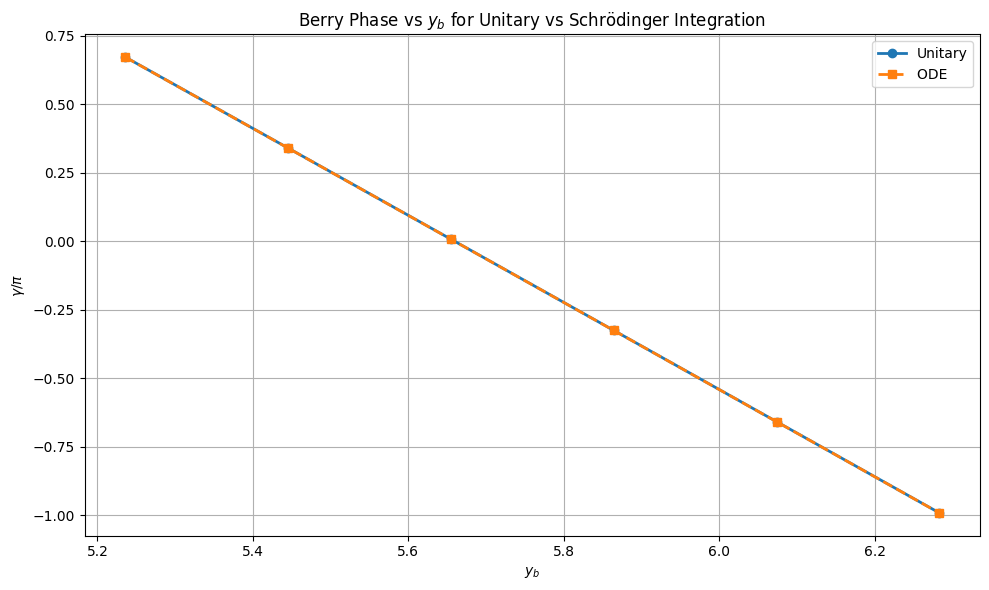

In [16]:
q1_min = 0
q2_star = 8

berry_phases = []

berry_phases_unitary = []
berry_phases_ode = []
unitaries = []

for yb in yb_values:
    #print(f"\nRunning for yb = {yb:.4f}")
    h1 = h1_position(2 * T, T, Lx, yt, y2, yb)
    h2 = np.array([Lx / 2, y2])

    psi_start = create_truncated_wavefunction(h1, h2, T, kappa, q1_min, q2_star, truncation_threshold=1e-2)
    dim = len(psi_start)
    U_total = np.eye(dim, dtype=complex)
    psi_final_ode = psi_start.copy()

    for i in range(3):
        t0 = 2*T + i * (T/3)
        t1 = t0 + T/3

        out = integrate_C1_or_C2_segment_truncated(
            t0, t1, T, Lx, yt, y2, yb, N_sites,
            psi_final_ode.copy(), kappa, q1_min, q2_star,
            save_file=None
        )

        U_seg = out["unitary"]
        unitaries.append(U_seg)
        U_total = U_seg @ U_total

        psi_final_ode = out["final_state"]

    psi_final_unitary = U_total @ psi_start
    overlap_U = np.vdot(psi_start, psi_final_unitary)
    phase_U = np.angle(overlap_U)
    berry_phases_unitary.append(phase_U)

    overlap_ode = np.vdot(psi_start, psi_final_ode)
    phase_ode = np.angle(overlap_ode)
    berry_phases_ode.append(phase_ode)

    #print(f"  Unitary Berry phase = {phase_U:.4f} rad ({phase_U / np.pi:.4f} π)")
    #print(f"  ODE     Berry phase = {phase_ode:.4f} rad ({phase_ode / np.pi:.4f} π)")


berry_phases_unitary = np.array(berry_phases_unitary)
berry_phases_ode = np.array(berry_phases_ode)

yb_values_rev = yb_values[::-1]


plt.figure(figsize=(10, 6))
plt.plot(yb_values_rev, berry_phases_unitary / np.pi, 'o-', label='Unitary', linewidth=2)
plt.plot(yb_values_rev, berry_phases_ode / np.pi, 's--', label='ODE ', linewidth=2)
plt.xlabel(r"$y_b$")
plt.ylabel(r"$\gamma/\pi$")
plt.title(r"Berry Phase vs $y_b$ for Unitary vs Schrödinger Integration")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


The unitaries are broken up into smaller segments and promoted to quantum circuit objects that are then appened at the end of a ground state preperation circuit for each $y_b$ value.

In [22]:
n_yb = len(yb_values)
dim = unitaries[0].shape[0]
n_qubits = int(np.log2(dim))

grouped = [unitaries[i*3:(i+1)*3] for i in range(n_yb)]
circuits = []

for i, U_group in enumerate(grouped):
    yb = yb_values[i]
    h1 = h1_position(2 * T, T, Lx, yt, y2, yb)
    h2 = np.array([Lx / 2, y2])
    
    psi_start = create_truncated_wavefunction(h1, h2, T, kappa, q1_min, q2_star, truncation_threshold=1e-2)
    alphas = compute_alphas(psi_start)  
    ground_state_circuit = create_ground_state_prep_3q(alphas) 
    qc = QuantumCircuit(n_qubits, name=f"yb_{yb:.4f}")
    
    qc.append(ground_state_circuit.reverse_bits().to_gate(label="GroundStatePrep"), range(n_qubits))
    
    for U in (U_group):
        gate = UnitaryGate(U, label="U_segment")
        qc.append(gate, range(n_qubits))

    circuits.append(qc)
print("Ground State Prep: ")
print(ground_state_circuit.draw(fold=100))
print("Ground state prep with braiding: ")
print(circuits[i].draw(fold=100))


Ground State Prep: 
     ┌─────────────┐                                                                         »
q_0: ┤ U3(π/2,0,π) ├────────o─────────────────■─────────────────o──────────────────o─────────»
     └─────────────┘┌───────┴───────┐┌────────┴────────┐        │                  │         »
q_1: ───────────────┤ U3(2.783,0,π) ├┤ U3(0.35856,0,π) ├────────o──────────────────■─────────»
                    └───────────────┘└─────────────────┘┌───────┴────────┐┌────────┴────────┐»
q_2: ───────────────────────────────────────────────────┤ U3(-2.735,0,0) ├┤ U3(-2.0744,0,0) ├»
                                                        └────────────────┘└─────────────────┘»
«                                            
«q_0: ─────────■──────────────────■──────────
«              │                  │          
«q_1: ─────────o──────────────────■──────────
«     ┌────────┴────────┐┌────────┴─────────┐
«q_2: ┤ U3(-1.0672,0,0) ├┤ U3(-0.40661,0,0) ├
«     └─────────────────┘└─────────────

Ancinilla qubit and related logic added to circuit for berry phase measurent described in reference. 

In [10]:
final_circuits = []
for i, U_group in enumerate(grouped):
    yb = yb_values[i]
    h1 = h1_position(2 * T, T, Lx, yt, y2, yb)
    h2 = np.array([Lx / 2, y2])
    
    psi_start = create_truncated_wavefunction(
        h1, h2, T, kappa, q1_min, q2_star, truncation_threshold=1e-2
    )
    alphas = compute_alphas(psi_start)
    ground_state_circuit = create_ground_state_prep_3q(alphas)

    qc = QuantumCircuit(1 + n_qubits, 1) 

    qc.h(0)

    qc.append(ground_state_circuit.reverse_bits().to_gate(label="GroundStatePrep"), range(1, 1 + n_qubits))


    for U in U_group:
        gate = UnitaryGate(U, label="U_segment")
        qc.append(gate.control(1), [0] + list(range(1, 1 + n_qubits)))

    qc.h(0)

    qc.measure(0, 0)

    final_circuits.append(qc)
print(final_circuits[1].draw(fold = 100))

            ┌───┐                                                  ┌───┐┌─┐
q_0: ───────┤ H ├──────────────■─────────────■─────────────■───────┤ H ├┤M├
     ┌──────┴───┴───────┐┌─────┴──────┐┌─────┴──────┐┌─────┴──────┐└───┘└╥┘
q_1: ┤0                 ├┤0           ├┤0           ├┤0           ├──────╫─
     │                  ││            ││            ││            │      ║ 
q_2: ┤1 GroundStatePrep ├┤1 U_segment ├┤1 U_segment ├┤1 U_segment ├──────╫─
     │                  ││            ││            ││            │      ║ 
q_3: ┤2                 ├┤2           ├┤2           ├┤2           ├──────╫─
     └──────────────────┘└────────────┘└────────────┘└────────────┘      ║ 
c: 1/════════════════════════════════════════════════════════════════════╩═
                                                                         0 


Circuit Simulation (not hardware optimized)

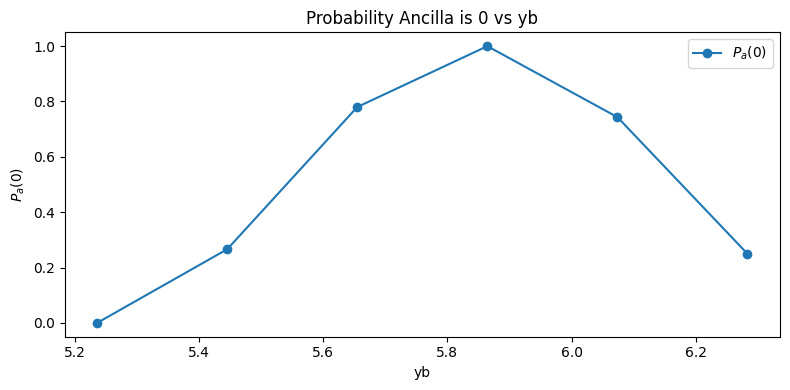

[-0.90985932 -0.61829587 -0.32565359  0.01406859  0.33833598  0.66702572]
[6.28318531 6.0737458  5.86430629 5.65486678 5.44542727 5.23598776]


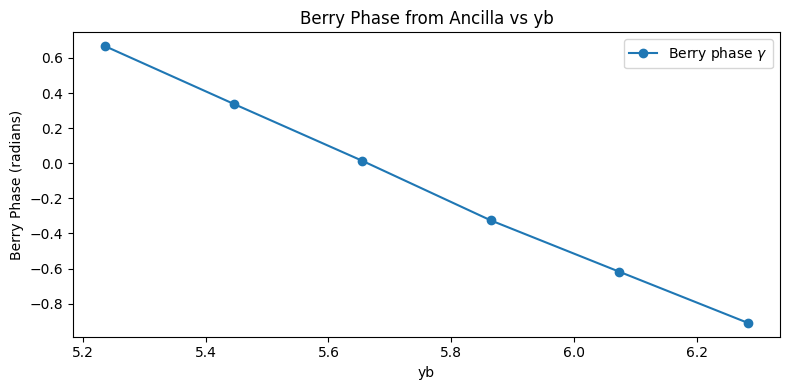

In [13]:
sim = AerSimulator()
shots = 2048
pa_0_list = []

for qc in final_circuits:
    compiled = transpile(qc, sim)
    result = sim.run(compiled, shots=shots).result()
    counts = result.get_counts()

    pa_0 = counts.get('0', 0) / shots
    pa_0_list.append(pa_0)

pa_0_array = np.array(pa_0_list)

berry_phases = np.arccos(2 * pa_0_array - 1)

plt.figure(figsize=(8, 4))
plt.plot(yb_values, pa_0_array, 'o-', label=r"$P_a(0)$")
plt.xlabel("yb")
plt.ylabel(r"$P_a(0)$")
plt.title("Probability Ancilla is 0 vs yb")
plt.legend()
plt.tight_layout()
plt.show()


berry_phases = berry_phases[::-1]

berry_phases[2] -= 2
berry_phases[1] -= 4
berry_phases[0] -= 6

print(berry_phases /np.pi)
print(yb_values)
berry_phases = berry_phases / np.pi


plt.figure(figsize=(8, 4))
plt.plot(yb_values, berry_phases , 'o-', label=r"Berry phase $\gamma$")
plt.xlabel("yb")
plt.ylabel(r"Berry Phase (radians)")
plt.title("Berry Phase from Ancilla vs yb")
plt.legend()
plt.tight_layout()
plt.show()
